# Random Forests vs. Neural Networks

## Comparing two common ML methods

This simple example compares the speed, accuracy (pattern matching, interpolation, and extrapolation) and functionality of Random Forest (RF) and Neural Network (NN) models.  The RF is faster and easier to implement, but this example shows that the high r2 scores that RF models produce can be deceptive.  While they fit their training data near perfectly, they do not handle systematic data gaps well.  They are poorly suited for interpolation and wholly incapable of extrapolation.  RF models are great for classification problems, but they are not well suited for mapping continuous functions.  NN models, on the other hand, are universal approximations.  They are capable of mapping any continuos function to an arbitrary degree of accuracy given sufficient training data.  They take more time and expertise to implement, but are much better suited for interpolation, and can even be used for extrapolation (given sufficient oversight).  Further they are more functional, their architecture is customizable, and you can calculate and plot partial first derivatives to see whats going on "under the hood".


In [1]:
## Import some standard packages and define a few functions

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

def Calc_VPD(TA, RH):
    # Calculate vapour pressure (hPa)
    # From TA (in celsius) and RH %
    ea_H = 0.61365*np.exp((17.502*TA)/(240.97+TA))
    e_H = RH*ea_H/100
    VPD = ea_H - e_H
    VPD = np.round(VPD*10,5)     # Limit precision
    return (VPD)

def Create_Grid(x1,x2,func=None):  
    # Create a 2d Grid of 2 X variables
    # Option to create grid of Y as function of X
    grid_x1,grid_x2 = np.meshgrid(x1,x2)
    flat_X=np.array([grid_x1.flatten(),grid_x2.flatten()])
    if func != None:
        flat_Y = func(flat_X[0],flat_X[1])
        grid_y = flat_Y.reshape(grid_x1.shape)
    else:
        grid_y = None
    return(flat_X,grid_x1,grid_x2,grid_y)


def Contour_Plot(ax,grid_x1,grid_x2,grid_y,cmap='bwr',norm=None,unit='',bins=None):
    # Plot a colormesh grid with contours

    if bins is None:
        bins = np.linspace(grid_y.min(),grid_y.max())
    
    def fmt(x):
        s = f"{x:.1f}"
        if s.endswith("0"):
            s = f"{x:.0f}"
        return rf"{s}"

    c = ax.pcolormesh(
        grid_x1,grid_x2,grid_y,
        cmap=cmap,
        norm=norm)
    cb = fig.colorbar(c)

    CS = ax.contour(
        grid_x1,grid_x2,grid_y,
        levels=bins,
        colors='k',
        )
    ax.clabel(CS, CS.levels[::2], inline=True, fmt=fmt, fontsize=10)

    ax = cb.ax
    xmin, xmax = ax.get_xlim()
    ax.hlines(bins, xmin, xmax, colors=['black'])
    ax.set_ylabel(unit)

## Sample Data: Environment Canada Burns Bog Climate Station

* Our goal is to estimate Vapor Pressure Deficit (VPD in hPa) from Air Temperature (Ta in C) and Relative Humidity (%).

,Ta,RH,VPD
count,66513.00,66513.00,66513.00
mean,10.39,82.67,3.16
std,7.07,18.07,4.59
min,-15.10,13.00,0.00
25%,5.80,70.00,0.23
50%,10.20,90.00,1.13
75%,14.90,98.00,4.29
max,37.50,100.00,46.40


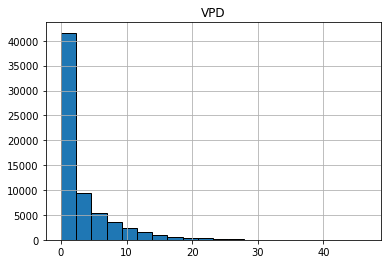

In [2]:
# Read/parse the input data
root_url = "Data/DELTA BURNS BOG.csv"
Data = pd.read_csv(root_url, parse_dates=['LOCAL_DATE'], low_memory=False)
Data = Data.set_index('LOCAL_DATE')
Data = (Data[['TEMP','RELATIVE_HUMIDITY']].dropna())
Data['VPD'] = Calc_VPD(Data['TEMP'],Data['RELATIVE_HUMIDITY'])
Data = Data.rename(columns={
    'TEMP':'Ta',
    'RELATIVE_HUMIDITY':'RH'
})
fig,ax=plt.subplots(1)
Data.hist(column='VPD',ax=ax,bins=20,edgecolor='k')

Data.describe().round(2)


### Plot VPD

Visualize the domain of the training data and the relationship between TA, RH, and VPD over a larger domain

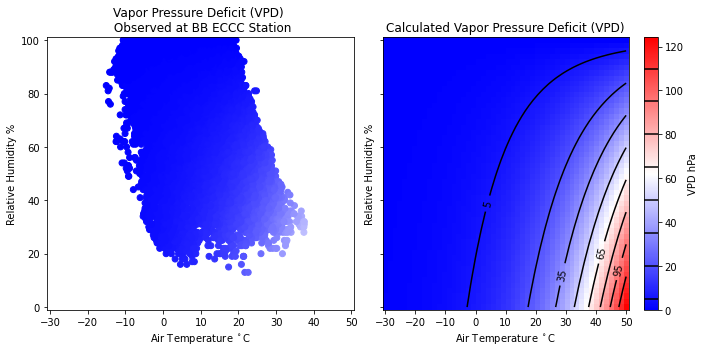

In [3]:
TA_range = np.linspace(-30,50) # Define a TA range (in C)
RH_range = np.linspace(0,100) # Possible RH values

range_TA_RH,grid_TA,grid_RH,grid_VPD = Create_Grid(TA_range,RH_range,Calc_VPD)

bins = np.arange(5,grid_VPD.max(),15)
unit = 'VPD hPa'
cmap = cm.bwr
norm = Normalize(vmin=0, vmax=grid_VPD.max(), clip=False)

fig,axes=plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)

ax = axes[0]
c = ax.scatter(Data['Ta'],Data['RH'],c=Data['VPD'],cmap=cmap,norm=norm)
ax.set_xlabel('Air Temperature $^\circ$C')
ax.set_ylabel('Relative Humidity %')
ax.set_title('Vapor Pressure Deficit (VPD) \n Observed at BB ECCC Station')

ax = axes[1]
Contour_Plot(ax,grid_TA,grid_RH,grid_VPD,cmap=cmap,norm=norm,unit=unit,bins=bins)
ax.set_xlabel('Air Temperature $^\circ$C')
ax.set_ylabel('Relative Humidity %')
ax.set_title('Calculated Vapor Pressure Deficit (VPD)')
plt.tight_layout()

# Format the training data

We'll use two example training sets.

## Full Dataset

All hourly observations from the BB ECCC station.  These data will be used to see how well the RF and NN can "pattern match".  We can also use these data to assess how well RF and NN are able to project beyond their training domain.

## Fill in the Blanks

Masking out the "middle" of the dataset, we'll see how well the models can estimate VPD, when there is a systematic bias in the dataset

In [4]:
X_vars = ['Ta', 'RH']
Y_var = 'VPD'

X_full = Data[X_vars].values
Y_full = Data[Y_var].values
print('Full Training Samples: ',Y_full.shape)

Mask = np.array([2.5,7.5])
# Masked dataset for training
x_mask = Data.loc[(
    (Data[Y_var]<Mask.min())|(Data[Y_var]>Mask.max())
    ),X_vars].values
y_mask = Data.loc[(
    (Data[Y_var]<Mask.min())|(Data[Y_var]>Mask.max())
    ),Y_var].values
print('Masked Samples: ',y_mask.shape)

# Missing values for assessing performance
x_missing = Data.loc[Data[Y_var].isin(y_mask)==False,X_vars].values
y_missing = Data.loc[Data[Y_var].isin(y_mask)==False,Y_var].values
print('Missing Samples: ',y_missing.shape)

Full Training Samples:  (66513,)
Masked Samples:  (51926,)
Missing Samples:  (14587,)


# Random Forest

The random forest is very simple to set up and it can be trained very fast with minimal computational overhead.  This makes them desireable for many applications (e.g., landscape classification).


The RF performs very well within the domain of the training data, but the mask data highlights that RF models are not well suited for interpolation, even in simple cases.  Further, estimating over a wider range of TA and RH conditions than were observed in the dataset highlights that the RF is incapable of making a projection beyond the domain of the data it was trained on.
    * This could be particularly problematic in high dimensional feature space where we cannot adequately visualize the domain of a training dataset

Test the Full Dataset
Training Time:
 3.73  Seconds

Validation metrics within training domain: 
r2 =  0.99997 
RMSE =  0.00066  VPD hPa


Test the Masked Dataset
Training Time:
 2.9  Seconds

Validation metrics within training domain: 
r2 =  0.99994 
RMSE =  0.00172  VPD hPa


Validation metrics for data gap: 
r2 =  -0.82239 
RMSE =  3.70188  VPD hPa

Validation metrics over wider Ta range (-30 to 50): 
r2 =  0.73788 
RMSE =  118.67351  VPD hPa
Minimum estimated VPD:  0.0
Maximum estimated VPD:  45.50813400000003


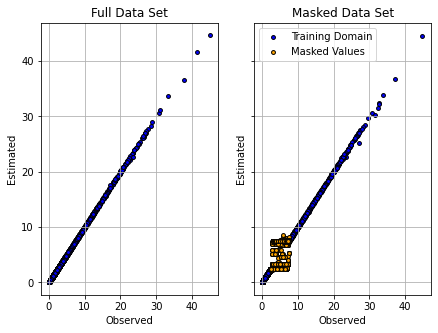

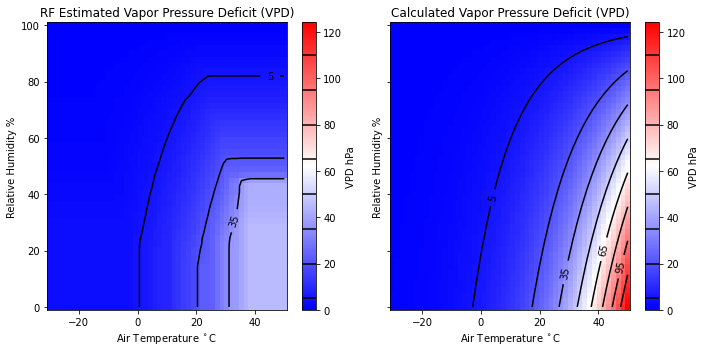

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

def RF_mod(x,y,ax=None):
    # Set 10% of training data aside for validation
    # The RF model bootstraps the training data (train/test splitting)
    # SO the validation data will give an "independent" assessment
    T1 = time.time()
    x_train, x_val, y_train, y_val = train_test_split(
        x, y, test_size=0.1, random_state=42)
    RF = RandomForestRegressor()
    RF.fit(x_train, y_train)
    T2 = time.time()
    print('Training Time:\n', np.round(T2 - T1,2),' Seconds')

    y_pred = RF.predict(x_val)
    R2 = metrics.r2_score(y_val,y_pred)
    RMSE = metrics.mean_squared_error(y_val,y_pred)
    print()
    print('Validation metrics within training domain: \nr2 = ',
            np.round(R2,5),'\nRMSE = ',np.round(RMSE,5),' '+unit)
    print()
    if ax is not None:
        ax.scatter(y_val,y_pred,label='Training Domain',color='blue',s=15,edgecolor='k')
        ax.set_ylabel('Estimated')
        ax.set_xlabel('Observed')
    ax.grid()
    return (RF)


fig,axes=plt.subplots(1,2,figsize=(7,5),sharex=True,sharey=True)

print('Test the Full Dataset')
# Time the run
RF_full = RF_mod(X_full,Y_full,ax=axes[0])
axes[0].set_title('Full Data Set')


print()
print('Test the Masked Dataset')
RF_mask = RF_mod(x_mask,y_mask,ax=axes[1])
y_fill = RF_mask.predict(x_missing)
R2 = metrics.r2_score(y_missing,y_fill)
RMSE = metrics.mean_squared_error(y_missing,y_fill)
print()
print('Validation metrics for data gap: \nr2 = ',
        np.round(R2,5),'\nRMSE = ',np.round(RMSE,5),' '+unit)
        
axes[1].scatter(y_missing,y_fill,label='Masked Values',color='orange',s=15,edgecolor='k')
axes[1].set_title('Masked Data Set')
axes[1].legend()

# Test extrapolation capabilities

RF_range_VPD = RF_full.predict(range_TA_RH.T)
RF_grid_VPD = RF_range_VPD.T.reshape(grid_TA.shape)

R2 = metrics.r2_score(grid_VPD.flatten(),RF_grid_VPD.flatten())
RMSE = metrics.mean_squared_error(grid_VPD.flatten(),RF_grid_VPD.flatten())
print()
print('Validation metrics over wider Ta range (-30 to 50): \nr2 = ',
        np.round(R2,5),'\nRMSE = ',np.round(RMSE,5),' '+unit)

print('Minimum estimated VPD: ',RF_grid_VPD.min())
print('Maximum estimated VPD: ',RF_grid_VPD.max())
        
fig,axes=plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
ax = axes[0]
Contour_Plot(ax,grid_TA,grid_RH,RF_grid_VPD,cmap = cmap,norm=norm,unit=unit,bins=bins)
ax.set_xlabel('Air Temperature $^\circ$C')
ax.set_ylabel('Relative Humidity %')
ax.set_title('RF Estimated Vapor Pressure Deficit (VPD)')

ax = axes[1]
Contour_Plot(ax,grid_TA,grid_RH,grid_VPD,cmap = cmap,norm=norm,unit=unit,bins=bins)
ax.set_xlabel('Air Temperature $^\circ$C')
ax.set_ylabel('Relative Humidity %')
ax.set_title('Calculated Vapor Pressure Deficit (VPD)')
plt.tight_layout()

# Inspecting the model

With RF models, we are limited what we can see from the model.  We can easily plot the feature importance, which is helpful in determining which variables the models find important.  We can also inspect individual trees to see the decision flow - but comparing each tree is difficult and in a typical RF trees are not limited in depth, so its impossible/unhelpful to view the full tree.

* A decision tree is just a complex series of binary yes/no decisions.  Its not attempting to approximate a continuous function, rather its creating a complex piecewise function uniquely fit to a dataset.  

* Random forest area  powerful tool for classification - they work great on qualitative data.  However, I don't think they are as useful for quantitative data.

Full RF Model Feature Importance  [0.26612567 0.73387433]

           depth        leaves
count  100.00000    100.000000
mean    19.51000  11332.900000
std      0.71767     39.238844
min     18.00000  11237.000000
25%     19.00000  11306.500000
50%     19.00000  11332.000000
75%     20.00000  11364.250000
max     21.00000  11410.000000


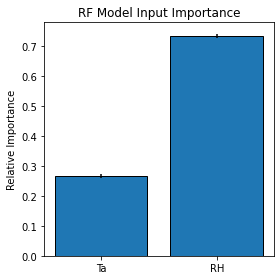

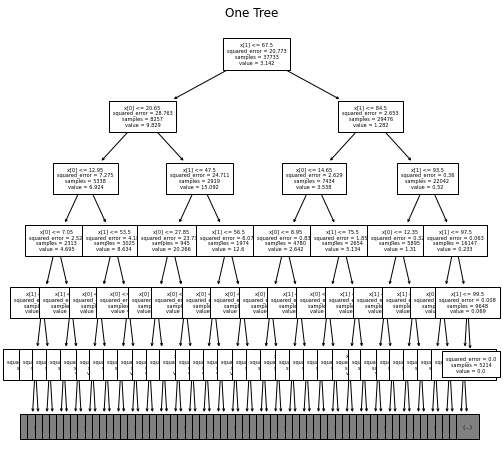

In [6]:
from sklearn import tree

print('Full RF Model Feature Importance ', RF_full.feature_importances_)
print()

# Get feature importance by tree in the forest
feature_importance = []
# Get a few other statistics
tree_Stats = {
    'depth':[],
    'leaves':[],
}
for t in RF_full.estimators_:
    feature_importance.append(t.feature_importances_)
    tree_Stats['depth'].append(t.get_depth())
    tree_Stats['leaves'].append(t.get_n_leaves())

tree_Stats = pd.DataFrame(data=tree_Stats)
print(tree_Stats.describe())
    
feature_importance = np.array(feature_importance)

fig,ax=plt.subplots(figsize=(4,4))
ax.bar(X_vars,feature_importance.mean(axis=0),
yerr=feature_importance.std(axis=0)/(RF_full.n_estimators**.5),edgecolor='k')
ax.set_ylabel('Relative Importance')
ax.set_title('RF Model Input Importance')
plt.tight_layout()

# Plot first tree to depth of 5
fig,ax = plt.subplots(1,figsize=(8,8))
tree.plot_tree(RF_full.estimators_[0],max_depth=5,ax=ax,fontsize=5)
ax.set_title('One Tree')
plt.show()


# Neural Network

* The NN ensemble is not as simple to set up 
    * It requires the user setup Tensorflow which can be tricky
    * Defining the model takes more time/consideration and more lines of code.

* One NN may over-fit training data, but an ensemble of NNs is more stable.  Similar to the distinction between a random forest and a decision tree.
    * The functions below alow us to define a model architecture then train an ensemble of as many models as we like.  In this example, we'll create an ensemble of 10 models.

* We are also using early stopping to prevent over-fitting, and the function save the model weights when training is stopped.  This allows us to reload the models later for further analysis.
    * We can use the model weights to calculate the relative importance of input features, similar to the feature importance statistic for RF models.
        * A **key advantage of the NN models** is that we can also use the model weights to calculate partial first derivatives with respect to each input variable.

    

In [28]:
import tensorflow as tf
from tensorflow import keras
from keras.models import model_from_json
import json
import os
from os import walk
import ipywidgets as widgets


def clean_dir(name):
    for (_, _, filenames) in walk('temp_files/'+name):
        for f in filenames:
            os.remove('temp_files/'+name+'/'+f)

def make_model(input_shape,hidden_nodes,name='Model'):
    try:
        os.mkdir("temp_files/"+name)
    except:
        clean_dir(name)
    input_layer = keras.layers.Input(input_shape)
    dense1 = keras.layers.Dense(
                                hidden_nodes,
                                activation='relu',
                                kernel_initializer="glorot_uniform",
                                bias_initializer="zeros"
                                )(input_layer)
    output_layer = keras.layers.Dense(1)(dense1)
    model = keras.models.Model(inputs=input_layer, outputs=output_layer,name=name)
    print(model.summary())
    model_json = model.to_json()
    with open(f"temp_files/{name}/model_architecture.json", "w") as json_file:
        json_file.write(model_json)

def train_model(x,y,i=0,name='Model',epochs = 250,batch_size = 32): 

    with open(f"temp_files/{name}/model_architecture.json", 'r') as json_file:
        architecture = json.load(json_file)
        model = model_from_json(json.dumps(architecture))

    callbacks = [
        keras.callbacks.ModelCheckpoint(
            f"temp_files/{name}/model_weights"+str(i)+".h5", save_best_only=True, monitor="val_loss"
        ),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=0),
    ]

    model.compile(
        optimizer="adam",
        loss="mean_squared_error",
    )

    model.fit(
        x,
        y,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_split=0.2,
        verbose=0,
    )

    tf.keras.backend.clear_session()

def predict_Model(name,N,x):

    with open(f"temp_files/{name}/model_architecture.json", 'r') as json_file:
        architecture = json.load(json_file)
        loaded_model = model_from_json(json.dumps(architecture))

    pred = []
    for i in range(N):
        loaded_model.load_weights(f"temp_files/{name}/model_weights"+str(i)+".h5")
        loaded_model.compile(loss='mean_squared_error', optimizer='adam')
        
        pred.append(loaded_model.predict(x))
    return(np.array(pred))


def Get_Weights(name, N):
    with open(f"temp_files/{name}/model_architecture.json", 'r') as json_file:
        architecture = json.load(json_file)
        # print(architecture)
        loaded_model = model_from_json(json.dumps(architecture))

    # Input layer
    W_i = []
    # Transposed Input layer
    W_i_T = []
    # Dense Input Layer
    W_d_i = []
    # Dense Output Layer
    W_d_o = []
    # Transposed Dense Output Layer
    W_d_o_T = []
    # Output Layer
    W_o = []

    for i in range(N):
        loaded_model.load_weights(f"temp_files/{name}/model_weights"+str(i)+".h5")
        W = loaded_model.get_weights()
        W_i.append(W[0])
        W_i_T.append(W[0].T)
        W_d_i.append(W[1])
        W_d_o.append(W[2])
        W_d_o_T.append(W[2].T)
        W_o.append(W[3])
    W_i = np.array(W_i)
    W_i_T = np.array(W_i_T)
    W_d_i = np.array(W_d_i)
    W_d_o = np.array(W_d_o)
    W_d_o_T = np.array(W_d_o_T)
    W_o = np.array(W_o)
    return(W_i,W_i_T,W_d_i,W_d_o,W_d_o_T,W_o)        

def get_Derivatives(name,N_models,X,y):
    W_i,W_i_T,W_d_i,W_d_o,W_d_o_T,W_o = Get_Weights(name,N_models)
    Op = []
    for i in range(X.shape[0]):
        Ip = X[i]
        H1 = (Ip*W_i_T).sum(axis=-1)+W_d_i
        # First derivative of the relu function
        # If using Sigmoid function, change to - H1 = 1/(1+np.exp(-H1))
        H1 = np.maximum(H1,np.zeros(H1.shape))
        H2 = (H1*W_d_o_T).sum(axis=-1)+W_o
        Op.append(H2.diagonal())
    Estimates = np.array(Op)
    SSD = []
    SAD = []
    Derivs = []
    for i in range(X.shape[1]):
        dj=[]
        for j in range(y.shape[0]):
            target = y[j]
            Xj = X[j][i]
            if np.isnan(target)==False:
                H1 = ((Xj*W_i[:,i,:]))+W_d_i
                AD = np.maximum(H1,np.zeros(H1.shape))
                AD[AD>0]=1
                # Sum = np.array([AD[:,h]*W_d_o[:,h,0]*W_i[:,i,h] for h in range(W_d_o.shape[1])]).sum(axis=0)
                Sum = (AD*W_d_o[:,:,0]*W_i[:,i,:]).sum(axis=0)
                Sj = 1
                dj.append(Sj*Sum)
        dji = np.array(dj)
        Derivs.append(dji)
        SSD.append(np.sum(dji**2,axis=0))
        SAD.append(np.sum(np.abs(dji),axis=0))
    Derivs = np.array(Derivs)
    SSD = np.array(SSD)
    RI_SSD = SSD/SSD.sum(axis=0)
    SAD = np.array(SAD)
    RI_SAD = SAD/SAD.sum(axis=0)
    return(RI_SSD,RI_SAD,Derivs,Estimates)

## Training the NN models 

* Training is also considerably slower
    * This model is being run on a GPU which helps speed things up.  It can be run on a system without a suitable GPD, but processing on a CPU alone is **much slower**

    * Ensembling increases accuracy but also increases training time.  This example uses an ensemble of N=10 randomly initialized networks trained the same randomly split training data as the RF model.
        * In practice its better to use different random splits for each model in the ensemble or use a systematic splitting method.  We use the same random split as the RF model here for a more direct comparison.


In [8]:
N_models = 3
progress = widgets.IntProgress(
    value=0,
    min=0,
    max=N_models,
    step=1,
    description='Training:',
    orientation='horizontal'
)
display(progress)

print('Test the Full Dataset')

# Leaving random state fixed here for more direct comparison with RF results
# In practice, it is better to train each model on separate splits
x_train, x_val, y_train, y_val = train_test_split(
    X_full,Y_full, test_size=0.1, random_state=42) 

make_model(input_shape=X_full.shape[1:],hidden_nodes=64)

T1 = time.time()
y_est,y_obs = [],[]
for i in range(N_models):
    progress.value=i
    train_model(x_train,y_train,i)
T2 = time.time()
progress.value=N_models
print('\nFull Training Time: ', np.round((T2 - T1)/60,2),' Minutes')
print('\nTime: Per Model', np.round((T2 - T1)/N_models,2),' Seconds')

print()
print()
print('Test the Masked Dataset')


# Leaving random state fixed here for more direct comparison with RF results
# In practice, it is better to train each model on separate splits
x_train, x_val_mask, y_train, y_val_mask = train_test_split(
    x_mask,y_mask, test_size=0.1, random_state=42) 

make_model(input_shape=x_mask.shape[1:],hidden_nodes=64,name='Masked_Model')

T1 = time.time()
y_est,y_obs = [],[]
for i in range(N_models):
    progress.value=i
    train_model(x_train,y_train,i,name='Masked_Model')
T2 = time.time()
progress.value=N_models
print('\nFull Training Time: ', np.round((T2 - T1)/60,2),' Minutes')
print('\nTime: Per Model', np.round((T2 - T1)/N_models,2),' Seconds')


IntProgress(value=0, description='Training:', max=3)

Test the Full Dataset
Model: "Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________
None

Full Training Time:  2.38  Minutes

Time: Per Model 47.63  Seconds


Test the Masked Dataset
Model: "Masked_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
____________________________________________________

## Validation

* The NN ensemble provides comparable fits to the RF model over the training domain.  
* It does a much better job with the data gap example, where the RF performed very poorly.
* It is even capable of extrapolating to make a reasonable guess at VPD even outside the range of Ta that it was trained on.
    * The further outside the training domain, the less accurate predictions will be ... but it does pretty well in this simple example

Test the Full Dataset

Validation metrics within training domain: 
r2 =  0.99927 
RMSE =  0.01511  VPD hPa

Test the Masked Dataset

Validation metrics within training domain: 
r2 =  0.99735 
RMSE =  0.0734  VPD hPa

Validation metrics for data gap: 
r2 =  0.70831 
RMSE =  0.59251  VPD hPa

Validation metrics over wider Ta range (-30 to 50): 
r2 =  0.86785 
RMSE =  59.83226  VPD hPa
Minimum estimated VPD:  -0.5000141
Maximum estimated VPD:  63.719116


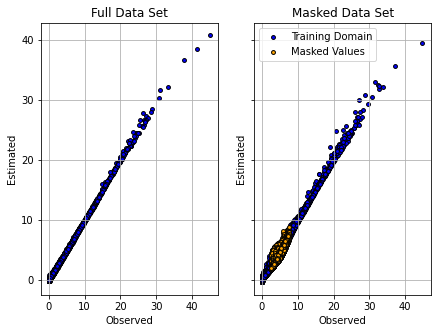

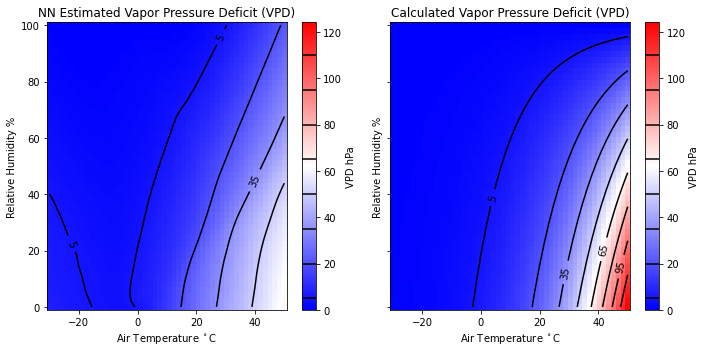

In [9]:
fig,axes=plt.subplots(1,2,figsize=(7,5),sharex=True,sharey=True)

print('Test the Full Dataset')

y_pred = predict_Model('Model',N_models,x_val)

R2 = metrics.r2_score(y_val,y_pred.mean(axis=0))
RMSE = metrics.mean_squared_error(y_val,y_pred.mean(axis=0))
print()
print('Validation metrics within training domain: \nr2 = ',
        np.round(R2,5),'\nRMSE = ',np.round(RMSE,5),' '+unit)

ax = axes[0]
ax.scatter(y_val,y_pred.mean(axis=0),label='Training Domain',color='blue',s=15,edgecolor='k')
ax.set_ylabel('Estimated')
ax.set_xlabel('Observed')
ax.grid()
ax.set_title('Full Data Set')

# Test interpolation capabilities
print()
print('Test the Masked Dataset')

y_pred_mask = predict_Model('Masked_Model',N_models,x_val_mask)
y_fill = predict_Model('Masked_Model',N_models,x_missing)

R2 = metrics.r2_score(y_val_mask,y_pred_mask.mean(axis=0))
RMSE = metrics.mean_squared_error(y_val_mask,y_pred_mask.mean(axis=0))
print()
print('Validation metrics within training domain: \nr2 = ',
        np.round(R2,5),'\nRMSE = ',np.round(RMSE,5),' '+unit)

R2 = metrics.r2_score(y_missing,y_fill.mean(axis=0))
RMSE = metrics.mean_squared_error(y_missing,y_fill.mean(axis=0))
print()
print('Validation metrics for data gap: \nr2 = ',
        np.round(R2,5),'\nRMSE = ',np.round(RMSE,5),' '+unit)

ax = axes[1]
ax.scatter(y_val_mask,y_pred_mask.mean(axis=0),label='Training Domain',color='blue',s=15,edgecolor='k')
ax.set_ylabel('Estimated')
ax.set_xlabel('Observed')
ax.scatter(y_missing,y_fill.mean(axis=0),label='Masked Values',color='orange',s=15,edgecolor='k')
ax.set_title('Masked Data Set')
ax.legend()
ax.grid()

# Test extrapolation capabilities

NN_range_VPD = predict_Model('Model',N_models,range_TA_RH.T)
NN_grid_VPD = NN_range_VPD.mean(axis=0).T.reshape(grid_TA.shape)


R2 = metrics.r2_score(grid_VPD.flatten(),NN_grid_VPD.flatten())
RMSE = metrics.mean_squared_error(grid_VPD.flatten(),NN_grid_VPD.flatten())
print()
print('Validation metrics over wider Ta range (-30 to 50): \nr2 = ',
        np.round(R2,5),'\nRMSE = ',np.round(RMSE,5),' '+unit)
        
print('Minimum estimated VPD: ',NN_grid_VPD.min())
print('Maximum estimated VPD: ',NN_grid_VPD.max())


fig,axes=plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
ax = axes[0]
Contour_Plot(ax,grid_TA,grid_RH,NN_grid_VPD,cmap = cmap,norm=norm,unit=unit,bins=bins)
ax.set_xlabel('Air Temperature $^\circ$C')
ax.set_ylabel('Relative Humidity %')
ax.set_title('NN Estimated Vapor Pressure Deficit (VPD)')

ax = axes[1]
Contour_Plot(ax,grid_TA,grid_RH,grid_VPD,cmap = cmap,norm=norm,unit=unit,bins=bins)
ax.set_xlabel('Air Temperature $^\circ$C')
ax.set_ylabel('Relative Humidity %')
ax.set_title('Calculated Vapor Pressure Deficit (VPD)')
plt.tight_layout()


## Model Inspection

* We can calculate the relative feature importance, as we can with the RF model.  But we can also calculate and plot partial first derivatives with respect to each input, which allows us to see whats going on in the model.  This is much more useful than plotting the individual decision trees, which is the best option for the RF model.
    * Note that the relative importance of the RF model and the NN ensemble are very different 
        - Gevery (2003) who initially proposed this method used the Sum of squared derivatives (SSD).  
        - This many unnecessarily penalize inputs with small (<1), but consistent derivatives, to get around this you can use the sum of absolute derivative (SAD) instead.

,count,mean,std,min,25%,50%,75%,max
dVPD_dTa,66513.0,0.050,0.015,-0.007,0.047,0.058,0.059,0.059
dVPD_dRH,66513.0,-0.004,0.001,-0.005,-0.005,-0.004,-0.002,-0.002
dVPD_dTa_se,66513.0,0.015,0.001,0.009,0.015,0.015,0.015,0.017
dVPD_dRH_se,66513.0,0.005,0.000,0.005,0.005,0.005,0.006,0.006
VPD_estimated,66513.0,3.141,4.569,-0.309,0.234,1.144,4.228,41.561
VPD,66513.0,3.165,4.587,0.000,0.230,1.134,4.291,46.396
Ta,66513.0,10.390,7.067,-15.100,5.800,10.200,14.900,37.500
RH,66513.0,82.666,18.073,13.000,70.000,90.000,98.000,100.000


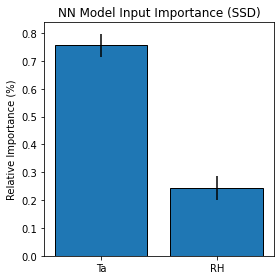

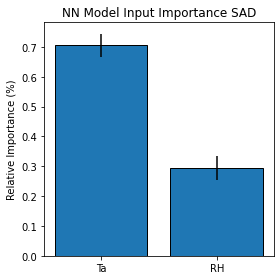

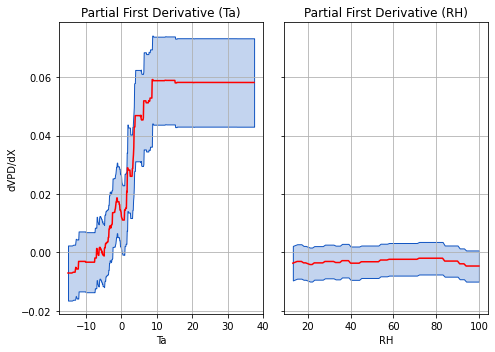

In [29]:
RI_SSD,RI_SAD,Derivatives,Estimates = get_Derivatives('Model',N_models, X_full, Y_full)

RI_mean = RI_SSD.mean(axis=1)
RI_se = RI_SSD.std(axis=1)/RI_SSD.shape[1]**.5

fig,ax=plt.subplots(figsize=(4,4))
ax.bar(X_vars,RI_mean,yerr=RI_se,edgecolor='k')
ax.set_ylabel('Relative Importance (%)')
ax.set_title('NN Model Input Importance (SSD)')
plt.tight_layout()


RI_mean = RI_SAD.mean(axis=1)
RI_se = RI_SAD.std(axis=1)/RI_SAD.shape[1]**.5

fig,ax=plt.subplots(figsize=(4,4))
ax.bar(X_vars,RI_mean,yerr=RI_se,edgecolor='k')
ax.set_ylabel('Relative Importance (%)')
ax.set_title('NN Model Input Importance SAD')
plt.tight_layout()


Estimates_mean = Estimates.mean(axis=1)

Model_Derivatives = pd.DataFrame(Derivatives.mean(axis=-1).T, columns = ['dVPD_d'+x for x in X_vars])
Model_Derivatives = Model_Derivatives.join(
    pd.DataFrame(Derivatives.std(axis=-1).T/Derivatives.shape[-1]**.5, columns = ['dVPD_d'+x+'_se' for x in X_vars])
)
Model_Derivatives['VPD_estimated'] = Estimates_mean
Model_Derivatives['VPD'] = Y_full
Model_Derivatives[X_vars] = X_full

def Plot_Derivs(Derivs,X,dy,ax):
    D = Derivs[[X,dy,dy+'_se']].sort_values(by=X)
    ax.fill_between(D[X],D[dy]-D[dy+'_se'],D[dy]+D[dy+'_se'],
                    facecolor='#1356c240',edgecolor='#1356c2')
    ax.plot(D[X],D[dy],color='r')
    ax.grid()
    ax.set_xlabel(X)


fig,ax = plt.subplots(1,2,figsize = (7,5),sharey=True)
Plot_Derivs(Model_Derivatives,'Ta','dVPD_dTa',ax[0])
Plot_Derivs(Model_Derivatives,'RH','dVPD_dRH',ax[1])
ax[0].set_ylabel('dVPD/dX')
ax[0].set_title('Partial First Derivative (Ta)')
ax[1].set_title('Partial First Derivative (RH)')

plt.tight_layout()


Model_Derivatives.describe().T.round(3)
